In [ ]:
#importing required model

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
from torchvision.transforms import ToTensor
import time
import copy

# Leading the CIFAR10 dataset

In [ ]:
# importing data sets 
torch.manual_seed(43)

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_X, val_X = random_split(dataset, [40000, 10000])
test_ds = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

image_datasets = {'train': train_X, 'val': val_X, 'test': test_ds}

batch_size = 128
train_loader = torch.utils.data.DataLoader(train_X, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_X, batch_size*2, num_workers=4, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size*2, num_workers=4, pin_memory=True)

dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")




Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


# **Part 1**

In [ ]:


def train_model(model, criterion, optimizer, scheduler, ne, as, ls):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(ne):
        print('Epoch {}/{}'.format(epoch, ne - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() 
            else:
                model.eval()

            loss_run = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                loss_run += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            loss_epoch = loss_run / dataset_sizes[phase]
            loss_stats[phase].append(loss_epoch)
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            accuracy_stats[phase].append(epoch_acc)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, loss_epoch, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Total training time: {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Maximum validation set Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def evaluate(model, phase):
    model.eval()  

    loss_run = 0.0
    running_corrects = 0

    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        loss_run += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    loss_epoch = loss_run / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    return loss_epoch, epoch_acc    

In [ ]:


model1 = models.resnet18(pretrained=False)
num1 = model1.fc.in_features
model1.fc = nn.Linear(num1, 10)
model1 = model1.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_rn = optim.Adam(model1.parameters(), lr=0.01)
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_rn, T_max=200)

In [ ]:
model1

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
accuracy1 = {'train': [], 'val': []}
loss1 = {'train': [], 'val': []}
num_epochs = 30
model1 = train_model(model1, criterion, optimizer_rn, exp_lr_scheduler, num_epochs, accuracy1, loss1)

Epoch 0/29
----------
train Loss: 1.8221 Acc: 0.3649
val Loss: 1.5922 Acc: 0.4301

Epoch 1/29
----------
train Loss: 1.3194 Acc: 0.5247
val Loss: 1.2139 Acc: 0.5650

Epoch 2/29
----------
train Loss: 1.0570 Acc: 0.6275
val Loss: 1.0397 Acc: 0.6331

Epoch 3/29
----------
train Loss: 0.8739 Acc: 0.6923
val Loss: 0.9388 Acc: 0.6685

Epoch 4/29
----------
train Loss: 0.7554 Acc: 0.7373
val Loss: 0.9722 Acc: 0.6726

Epoch 5/29
----------
train Loss: 0.6547 Acc: 0.7713
val Loss: 0.8458 Acc: 0.7068

Epoch 6/29
----------
train Loss: 0.5487 Acc: 0.8093
val Loss: 0.8503 Acc: 0.7196

Epoch 7/29
----------
train Loss: 0.4593 Acc: 0.8404
val Loss: 0.8718 Acc: 0.7170

Epoch 8/29
----------
train Loss: 0.3808 Acc: 0.8683
val Loss: 0.8856 Acc: 0.7263

Epoch 9/29
----------
train Loss: 0.3083 Acc: 0.8948
val Loss: 0.9201 Acc: 0.7223

Epoch 10/29
----------
train Loss: 0.2528 Acc: 0.9118
val Loss: 1.0543 Acc: 0.7145

Epoch 11/29
----------
train Loss: 0.2025 Acc: 0.9293
val Loss: 1.1012 Acc: 0.7233

Ep

#Plotting Graphs

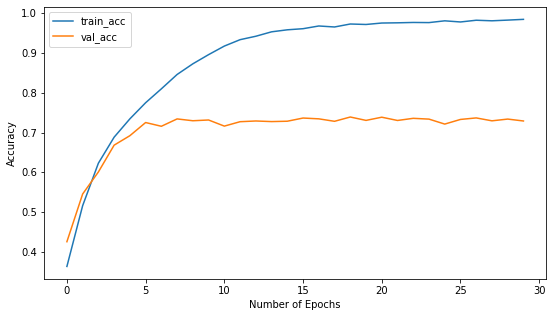

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(accuracy1['train'], label='train_acc')
plt.plot(accuracy1['val'], label='val_acc')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()


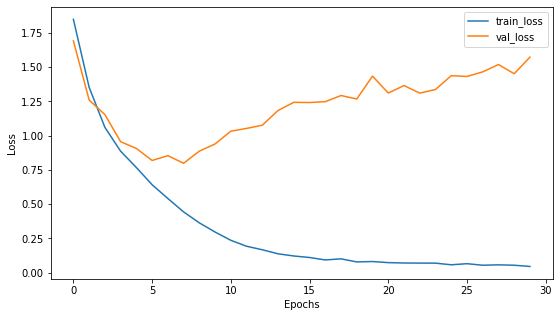

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(loss1['train'], label='train_loss')
plt.plot(loss1['val'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


In [ ]:
import pandas as pd
df = pd.DataFrame(accuracy1['train'])
df.to_csv('acc_train1.csv') 

In [ ]:
data = pd.read_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
_, acc_train1 = evaluate(model1, 'train')
_, acc_val1 = evaluate(model1, 'val')
_, acc_test1 = evaluate(model1, 'test')

print('Training  Accuracy:   %.3f' % acc_train1)
print('Validation Accuracy:  %.3f' % acc_val1)
print('Testing Accuracy:     %.3f' % acc_test1)

Training  Accuracy:   0.986
Validation Accuracy:  0.739
Testing Accuracy:     0.738


# Part 2

Finetuning CONVNet
(a) Keeping pretrained = true but allowing weights to be learned in all layers

In [ ]:
model2 = models.resnet18(pretrained=True)
num2 = model2.fc.in_features

model2.fc = nn.Linear(num2, 10)

model2 = model2.to(device)
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model2.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_ft, T_max=200)

In [ ]:
model2

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
acc2 = {'train': [], 'val': []}
loss2 = {'train': [], 'val': []}
num_epochs = 30
model2 = train_model(model2, criterion, optimizer_ft, exp_lr_scheduler, num_epochs, accuracy_ft, loss_ft)

Epoch 0/29
----------
train Loss: 0.0375 Acc: 0.9872
val Loss: 0.9793 Acc: 0.7992

Epoch 1/29
----------
train Loss: 0.0443 Acc: 0.9856
val Loss: 0.9129 Acc: 0.8040

Epoch 2/29
----------
train Loss: 0.0304 Acc: 0.9897
val Loss: 0.9631 Acc: 0.8050

Epoch 3/29
----------
train Loss: 0.0288 Acc: 0.9903
val Loss: 1.0289 Acc: 0.8026

Epoch 4/29
----------
train Loss: 0.0311 Acc: 0.9896
val Loss: 0.9462 Acc: 0.8112

Epoch 5/29
----------
train Loss: 0.0256 Acc: 0.9915
val Loss: 1.0380 Acc: 0.8004

Epoch 6/29
----------
train Loss: 0.0259 Acc: 0.9914
val Loss: 1.0196 Acc: 0.8022

Epoch 7/29
----------
train Loss: 0.0262 Acc: 0.9915
val Loss: 0.9820 Acc: 0.8044

Epoch 8/29
----------
train Loss: 0.0251 Acc: 0.9917
val Loss: 1.0231 Acc: 0.8047

Epoch 9/29
----------
train Loss: 0.0329 Acc: 0.9896
val Loss: 1.0241 Acc: 0.8038

Epoch 10/29
----------
train Loss: 0.0207 Acc: 0.9933
val Loss: 1.0328 Acc: 0.8061

Epoch 11/29
----------
train Loss: 0.0239 Acc: 0.9928
val Loss: 1.0460 Acc: 0.8029

Ep

In [ ]:
model2 = train_model(model2, criterion, optimizer_ft, exp_lr_scheduler, num_epochs, accuracy_ft, loss_ft)

Epoch 0/29
----------
train Loss: 0.9207 Acc: 0.6886
val Loss: 0.7855 Acc: 0.7319

Epoch 1/29
----------
train Loss: 0.6075 Acc: 0.7962
val Loss: 0.6587 Acc: 0.7747

Epoch 2/29
----------
train Loss: 0.4620 Acc: 0.8447
val Loss: 0.7031 Acc: 0.7671

Epoch 3/29
----------
train Loss: 0.3592 Acc: 0.8785
val Loss: 0.6395 Acc: 0.7923

Epoch 4/29
----------
train Loss: 0.2823 Acc: 0.9032
val Loss: 0.7234 Acc: 0.7773

Epoch 5/29
----------
train Loss: 0.2285 Acc: 0.9228
val Loss: 0.6578 Acc: 0.8042

Epoch 6/29
----------
train Loss: 0.1738 Acc: 0.9421
val Loss: 0.7463 Acc: 0.7899

Epoch 7/29
----------
train Loss: 0.1466 Acc: 0.9501
val Loss: 0.7097 Acc: 0.8050

Epoch 8/29
----------
train Loss: 0.1272 Acc: 0.9569
val Loss: 0.7813 Acc: 0.8050

Epoch 9/29
----------
train Loss: 0.1074 Acc: 0.9640
val Loss: 0.8037 Acc: 0.7900

Epoch 10/29
----------
train Loss: 0.0963 Acc: 0.9671
val Loss: 0.8211 Acc: 0.8002

Epoch 11/29
----------
train Loss: 0.0812 Acc: 0.9730
val Loss: 0.8740 Acc: 0.7978

Ep

#Plotting Graphs

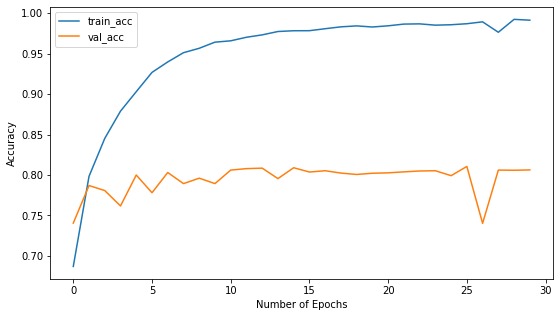

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(accuracy_ft['train'], label='train_acc')
plt.plot(accuracy_ft['val'], label='val_acc')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

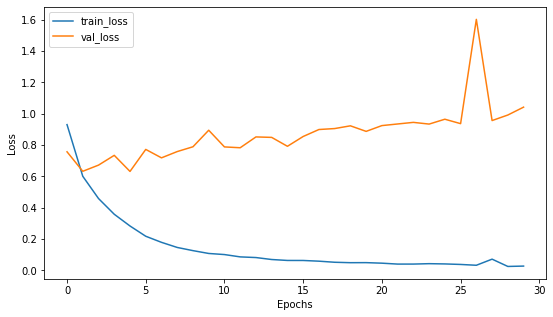

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(loss_ft['train'], label='train_loss')
plt.plot(loss_ft['val'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
_, train_acc_ft = evaluate(model2, 'train')
_, val_acc_ft = evaluate(model2, 'val')
_, test_acc_ft = evaluate(model2, 'test')

print('Training  Accuracy:   %.3f' % train_acc_ft)
print('Validation Accuracy:  %.3f' % val_acc_ft)
print('Testing Accuracy:     %.3f' % test_acc_ft)

Training  Accuracy:   0.995
Validation Accuracy:  0.811
Testing Accuracy:     0.804


comparison between the previous model and base model

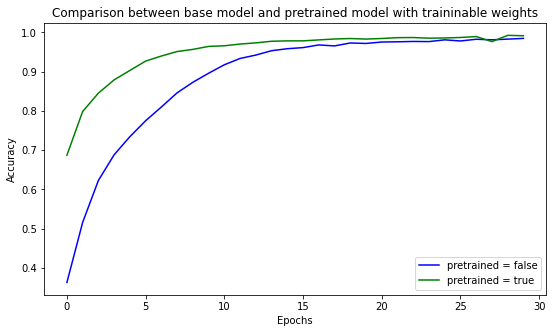

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(accuracy1['train'], 'b', label='pretrained = false')
plt.plot(accuracy_ft['train'], 'g',label='pretrained = true')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Comparison between base model and pretrained model with traininable weights')
plt.legend()

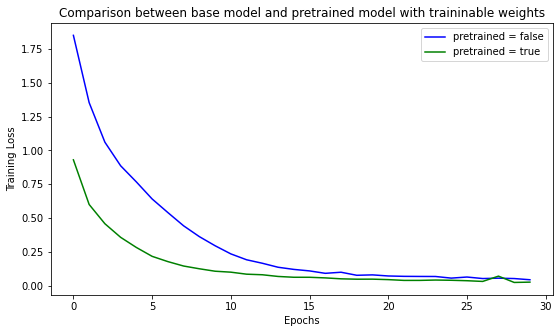

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(loss1['train'], 'b', label='pretrained = false')
plt.plot(loss_ft['train'], 'g',label='pretrained = true')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Comparison between base model and pretrained model with traininable weights')
plt.legend()

#Finetuning (b) 
This time, we keep the weights of the initial layers fixed and add some layers in the end which will be trained. Idea is that initial weights primarily recognise simple features independent of dataset and so initial layers' pretrained weights on the ImageNet dataset can be used on the CIFAR10 

In [ ]:
model3 = torchvision.models.resnet18(pretrained=True)


ct = 0
for name, child in model3.named_children():
    index += 1
    if index < 7:
        for name2, params in child.named_parameters():
            params.requires_grad = False

num2 = model3.fc.in_features

model3.fc = nn.Sequential(
    nn.Linear(num2, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(128, 128), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(64, 32), nn.ReLU(), 
    nn.Linear(32, 10))


model3 = model3.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.Adam(model3.parameters(), lr=0.001)

exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer_conv, T_max=100)

In [ ]:
model3

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
accuracy3 = {'train': [], 'val': []}
loss3 = {'train': [], 'val': []}
num_epochs = 30
model3 = train_model(model3, criterion, optimizer_conv, exp_lr_scheduler, num_epochs, accuracy3, loss3)

Epoch 0/29
----------
train Loss: 1.3017 Acc: 0.5232
val Loss: 0.9210 Acc: 0.6668

Epoch 1/29
----------
train Loss: 0.8541 Acc: 0.7197
val Loss: 0.7577 Acc: 0.7567

Epoch 2/29
----------
train Loss: 0.6780 Acc: 0.7956
val Loss: 0.7229 Acc: 0.7714

Epoch 3/29
----------
train Loss: 0.5549 Acc: 0.8324
val Loss: 0.7495 Acc: 0.7687

Epoch 4/29
----------
train Loss: 0.4654 Acc: 0.8593
val Loss: 0.7526 Acc: 0.7762

Epoch 5/29
----------
train Loss: 0.3945 Acc: 0.8820
val Loss: 0.7655 Acc: 0.7850

Epoch 6/29
----------
train Loss: 0.3323 Acc: 0.9044
val Loss: 0.7982 Acc: 0.7805

Epoch 7/29
----------
train Loss: 0.2783 Acc: 0.9197
val Loss: 0.8512 Acc: 0.7848

Epoch 8/29
----------
train Loss: 0.2361 Acc: 0.9329
val Loss: 0.8664 Acc: 0.7889

Epoch 9/29
----------
train Loss: 0.1950 Acc: 0.9447
val Loss: 0.8868 Acc: 0.7887

Epoch 10/29
----------
train Loss: 0.1716 Acc: 0.9510
val Loss: 0.9275 Acc: 0.7907

Epoch 11/29
----------
train Loss: 0.1519 Acc: 0.9570
val Loss: 0.9623 Acc: 0.7862

Ep

#Plotting Graphs

fig = plt.figure(figsize=(9,5))
plt.plot(accuracy3['train'], label='train_acc')
plt.plot(accuracy3['val'], label='val_acc')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.legend()

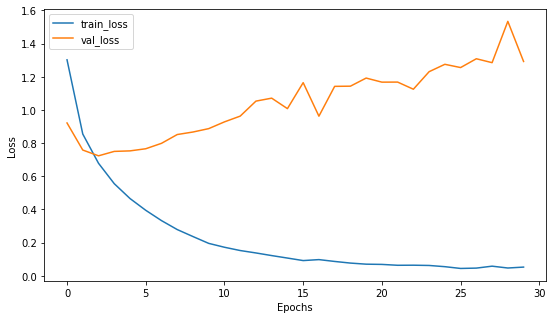

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(loss3['train'], label='train_loss')
plt.plot(loss3['val'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
_, acc_train3 = evaluate(model3, 'train')
_, acc_val3 = evaluate(model3, 'val')
_, acc_test3 = evaluate(model3, 'test')

print('Training  Accuracy:   %.3f' % acc_train3)
print('Validation Accuracy:  %.3f' % acc_val3)
print('Testing Accuracy:     %.3f' % acc_test3)

Training  Accuracy:   0.995
Validation Accuracy:  0.791
Testing Accuracy:     0.792


# Comparison of the best version of the three finetuning methods


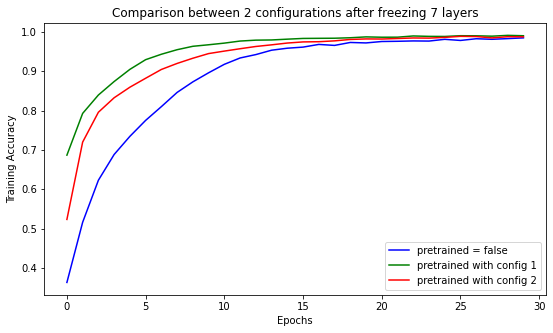

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(accuracy1['train'], 'b', label='pretrained = false')
plt.plot(accuracy_conv['train'][0:30], 'g',label='pretrained with config 1')
plt.plot(accuracy3['train'], 'r',label='pretrained with config 2')

plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Comparison between 2 configurations after freezing 7 layers')
plt.legend()

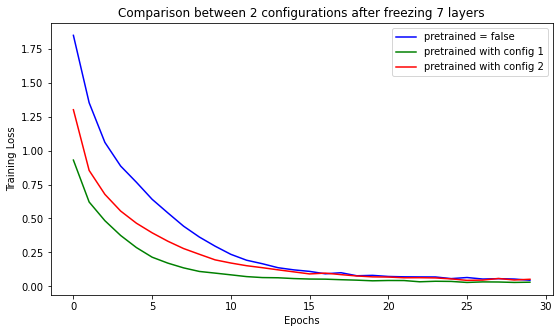

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(loss1['train'], 'b', label='pretrained = false')
plt.plot(loss_conv['train'][0:30], 'g',label='pretrained with config 1')
plt.plot(loss3['train'], 'r',label='pretrained with config 2')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Comparison between 2 configurations after freezing 7 layers')
plt.legend()

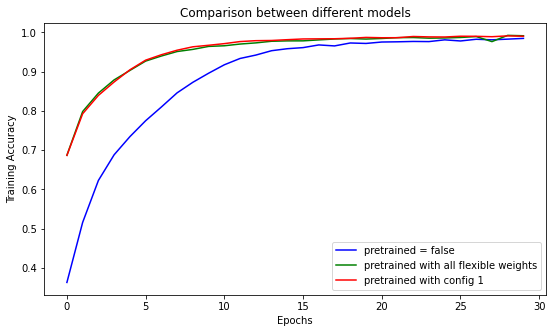

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(accuracy1['train'], 'b', label='pretrained = false')
plt.plot(accuracy_ft['train'][0:30], 'g',label='pretrained with all flexible weights')
plt.plot(accuracy_conv['train'], 'r',label='pretrained with config 1')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.title('Comparison between different models')
plt.legend()

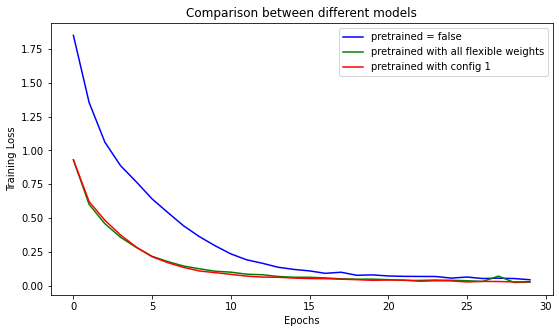

In [ ]:
fig = plt.figure(figsize=(9,5))
plt.plot(loss1['train'], 'b', label='pretrained = false')
plt.plot(loss_ft['train'][0:30], 'g',label='pretrained with all flexible weights')
plt.plot(loss_conv['train'], 'r',label='pretrained with config 1')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Comparison between different models')
plt.legend()

#Acknowledgement
There are few parts of the assignment where we discussed some aspects with another group (Raghav Gupta and Prakhar Kanchan). This was on a collaborative level, such as sending some links to resources, PyTorch tutorials and some debugging tips. The collaboration was strictly limited to what is permitted in other EE and CSE dept. assignment courses. In no way have copied, cheated or violated the code of conduct.